# QuBruin Tutorial 1: Trotterization of the Ising model 

In this tutorial, we present a Trotterization of the 1D Ising model to demonstrate the new digital capabilities of Bloqade, including for loops and maps. We simulate both an ordered and unordered phase, along with the transition between these phases. In particular, we consider an Ising model with a transverse field:
$$
H = -J \sum_{i=0}^{L-1} Z_i Z_{i+1} - h \sum_{i=0}^{L-1} X_i.
$$
Here, $J$ is the spin coupling strength and $h$ is the magnetic field strength. We use periodic boundary conditions, i.e. $Z_0 = Z_L$.\
To begin simulating this problem, we trotterize the Hamiltonian using the Lie-Trotter formula:
$$ e^{(A + B) \Delta t} = e^{A\Delta t} e^{B\Delta t} + O (\Delta t)^2. $$
Thus we may simulate the Ising model by implementing successive $ZZ$ gates and $X$ gates.

We first import the required packages:

In [1]:
pip install bloqade-pyqrack[pyqrack-cuda]

zsh:1: no matches found: bloqade-pyqrack[pyqrack-cuda]
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Uncomment the two below lines if necessary 
# !pip install Cirq 
# !pip install ply
from bloqade import qasm2
import math
import numpy as np
from bloqade.pyqrack import PyQrack
from kirin.dialects import ilist
from collections import Counter
from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin import ir
from kirin.rewrite import Walk
from bloqade.qasm2.passes import UOpToParallel, QASM2Fold
import matplotlib.pyplot as plt

import warnings # this is just because of a Cirq warning that will show up
warnings.filterwarnings("ignore") # "                      "


Let us break apart a time evolution of time $t$ into $s$ steps of $\Delta t$. We may model each time step with the following Trotterization, which takes heavy advantage of the new ***for*** structure.

In [14]:
def SpinChainLieTrotterUnopt(n: int, time: int, steps: int, parallelize: bool = True):
    n_qubits = int(2**n)

    # each Trotter layer
    @qasm2.extended
    def trotter_layer(qreg: qasm2.QReg, timestep: int, J: int, h: int):
        for i in range(n_qubits):
            qasm2.cx(qreg[i], qreg[(i+1)%n_qubits])
            qasm2.rz(qreg[(i+1)%n_qubits], 2*J*timestep)
            qasm2.cx(qreg[i], qreg[(i+1)%n_qubits])
        for i in range(n_qubits):
            qasm2.rx(qreg[i], 2*h*timestep)

    # the total time evolution of the Hamiltonian
    @qasm2.extended
    def SpinChainLieTrotterUnopt_program():
        if time == 0:
            creg = qasm2.creg(n_qubits) # since we are intitializing all states in spin up anyways
            return creg

        qreg = qasm2.qreg(n_qubits)
        creg = qasm2.creg(n_qubits)

        J = 0.2
        h = 1.2
        timestep = time/steps
        for i in range(steps):
            trotter_layer(qreg, timestep, J, h)

        for i in range(n_qubits):
            qasm2.measure(qreg[i],creg[i])

        return creg

    return SpinChainLieTrotterUnopt_program

We are interested in tracking the evolution of the **magnetization** over time, which is the expectation value of the spin in the Z direction. This may be simply extracted by repeatedly measuring out the result of our circuit in the computational basis.

In [15]:
time_interval = 0.5
steps = 24
N = 2
no_noise_2_qubits_lie = []

# determine the magnetization at each time step
for i in range(steps):
    kernel = SpinChainLieTrotterUnopt(N, time_interval*i, i)

    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel, _shots=100)

    def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))

    counts = to_bitstrings(results)

    # calculate the magnetization
    total_magnetization = 0
    for key, value in counts.items():
        spin_down = str(key).count('1')
        total_magnetization += value*spin_down * (-1) + value*(2**N - spin_down)

    print("Time " + str(time_interval*i) + ": " + str(total_magnetization/100))
    no_noise_2_qubits_lie.append(total_magnetization/100)

Time 0.0: 4.0
Time 0.5: 1.52
Time 1.0: -2.92
Time 1.5: -3.5
Time 2.0: 0.94
Time 2.5: 3.82
Time 3.0: 2.1
Time 3.5: -2.16
Time 4.0: -3.9
Time 4.5: -0.9
Time 5.0: 3.42
Time 5.5: 2.86
Time 6.0: -1.56
Time 6.5: -3.94
Time 7.0: -1.38
Time 7.5: 2.88
Time 8.0: 3.72
Time 8.5: -0.48
Time 9.0: -3.8
Time 9.5: -2.38
Time 10.0: 2.32
Time 10.5: 3.94
Time 11.0: 0.62
Time 11.5: -3.56


Then, we may plot our results.

Text(0.5, 1.0, '1D Ising chain magnetization over time on Bloqade (4 qubits, no noise, O(t^2))')

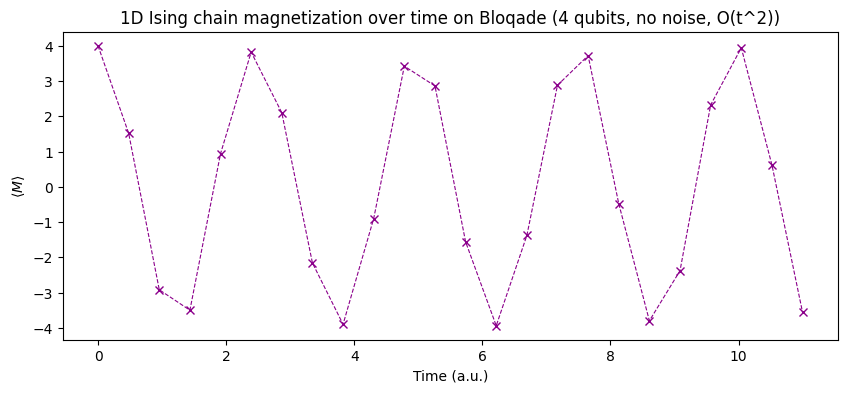

In [16]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 24)
plt.plot(t, no_noise_2_qubits_lie, marker="x", c="darkmagenta", ls="dashed", lw=0.8)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle M \rangle$")
plt.title("1D Ising chain magnetization over time on Bloqade (4 qubits, no noise, O(t^2))")

This is not a very good result. In the domain of $J, h$ that we had selected, we expect the result to converge to near zero magnetization rapidly. Let us try again, this time using the parallelization feature of Bloqade. To aid the optimizer, we notice that the $ZZ$ interactions commute with one another so that we may place them into two layers, regardless of the number of qubits.\
We use the following optimizer, which is the same one as in QuEra's GHZ state tutorial:

In [17]:
@ir.dialect_group(qasm2.extended)
def extended_opt(self):
    native_rewrite = Walk(RydbergGateSetRewriteRule(self)) # use Kirin's functionality to walk code line by line while applying neutral-atom gate decomposition as defined in Bloqade
    parallelize_pass = UOpToParallel(self) # review the code and apply parallelization using a heuristic
    agg_fold = QASM2Fold(self) # supports parallelization by unfolding loops to search for parallelization opportunities

    # here we define our new compiler pass
    def run_pass(
        kernel: ir.Method,
        *,
        fold: bool = True,
        typeinfer: bool = True,
        parallelize: bool = False,
    ):
        assert qasm2.extended.run_pass is not None
        qasm2.extended.run_pass(kernel, fold=fold, typeinfer=typeinfer) # apply the original run_pass to the lowered kernel
        native_rewrite.rewrite(kernel.code) # decompose all gates in the circuit to neutral atom gate set

        # here goes our parallelization optimizer; the order of the commands here matters!
        if parallelize:
            agg_fold.fixpoint(kernel)
            parallelize_pass(kernel)

    return run_pass

In [18]:
def SpinChainLieTrotterParallel(n: int, time: int, steps: int, parallelize: bool = True):
    n_qubits = int(2**n)
    
    @extended_opt
    def trotter_layer(qreg: qasm2.QReg, timestep: int, J: int, h: int): #puts commuting ZZ in parallel
        for i in range(0,n_qubits, 2):
            qasm2.cx(qreg[i], qreg[(i+1)%n_qubits])
            qasm2.rz(qreg[(i+1)%n_qubits], 2*J*timestep)
            qasm2.cx(qreg[i], qreg[(i+1)%n_qubits])
        for i in range(1,n_qubits, 2):
            qasm2.cx(qreg[i], qreg[(i+1)%n_qubits])
            qasm2.rz(qreg[(i+1)%n_qubits], 2*J*timestep)
            qasm2.cx(qreg[i], qreg[(i+1)%n_qubits])
        for i in range(n_qubits):
            qasm2.rx(qreg[i], 2*h*timestep)

    @extended_opt(parallelize=parallelize)
    def SpinChainLieTrotterParallel_program():
        if time == 0: 
            creg = qasm2.creg(n_qubits) 
            return creg
        
        qreg = qasm2.qreg(n_qubits)
        creg = qasm2.creg(n_qubits)

        J = 0.2 
        h = 1.2 
        timestep = time/steps 
        for i in range(steps): 
            trotter_layer(qreg, timestep, J, h)
        
        for i in range(n_qubits):
            qasm2.measure(qreg[i],creg[i])

        return creg

    return SpinChainLieTrotterParallel_program

We test the code as before:

In [51]:
time_interval = 0.5
steps = 24
N = 2
parallel_vals = [] 

for i in range(steps):
    kernel = SpinChainLieTrotterParallel(N, time_interval*i, i)
    
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = str(key).count('1')
        total_magnetization += value*spin_down * (-1) + value*(2**N - spin_down)

    print("Time " + str(time_interval*i) + ": " + str(total_magnetization/100))
    parallel_vals.append(total_magnetization/100) 

Time 0.0: 4.0
Time 0.5: 1.52
Time 1.0: -2.86
Time 1.5: -3.3
Time 2.0: 0.5
Time 2.5: 2.74
Time 3.0: 2.08
Time 3.5: -1.24
Time 4.0: -2.22
Time 4.5: -0.8
Time 5.0: 0.56
Time 5.5: 1.0
Time 6.0: -0.36
Time 6.5: -0.78
Time 7.0: 0.34
Time 7.5: -0.4
Time 8.0: -0.1
Time 8.5: 0.46
Time 9.0: 0.72
Time 9.5: 0.82
Time 10.0: -0.62
Time 10.5: -0.86
Time 11.0: 0.16
Time 11.5: 0.58


Text(0.5, 1.0, '1D Ising chain magnetization over time on Bloqade (4 qubits, optimized, no noise, O(t^2))')

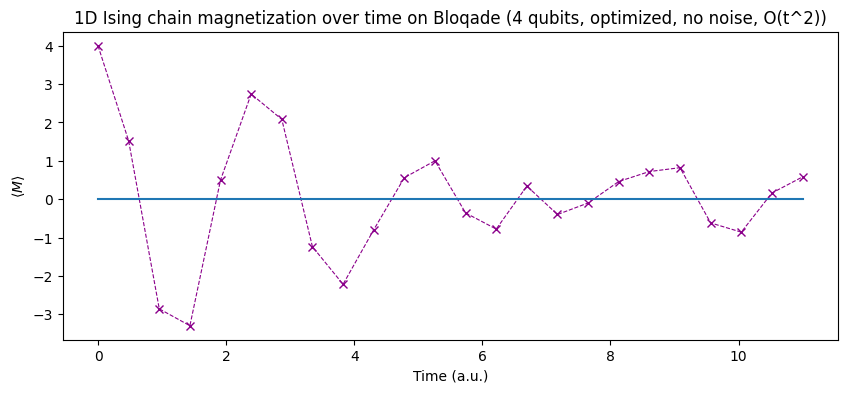

In [52]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 24)
plt.plot(t, parallel_vals, marker="x", c="darkmagenta", ls="dashed", lw=0.8)
plt.xlabel("Time (a.u.)")
plt.plot(t, np.zeros(24))
plt.ylabel(r"$\langle M \rangle$")
plt.title("1D Ising chain magnetization over time on Bloqade (4 qubits, optimized, no noise, O(t^2))") 

As we can see, this is a much more meaningful result. We see the spins rapidly equilibriate around a magnetization of 0.\
We may also explicitly call the natively parallelizable gates via the ```parallel.u``` and ```parallel.cz``` commands, instead of using the heuristic optimizer. To make this code easier to read, we have included the gate in a comment above each new line. Additionally, recalling that CZ gates are symmetric in their choice of "control" and "target" qubits allows the implementation to simplify slightly.

In [42]:
def SpinChainLieTrotterExplicitParallel(n: int, time: int, steps: int, parallelize: bool = True):
    n_qubits = int(2**n)

    @qasm2.extended
    def trotter_layer(qreg: qasm2.QReg, timestep: int, J: int, h: int): #puts commuting ZZ in parallel
        def get_qubit(x: int):
            return qreg[x % n_qubits]
            
        even_qubits = ilist.map(fn=get_qubit, collection=range(0, n_qubits, 2))
        even_qubits_alt = ilist.map(fn=get_qubit, collection=range(2, n_qubits+1, 2))
        odd_qubits = ilist.map(fn=get_qubit, collection=range(1, n_qubits, 2))
        all_qubits = ilist.map(fn=get_qubit, collection=range(n_qubits))

        # hadamard
        qasm2.parallel.u(qargs=odd_qubits, theta=math.pi/2, phi=0, lam=math.pi)
        # cz
        qasm2.parallel.cz(ctrls=even_qubits, qargs=odd_qubits)
        # rx
        qasm2.parallel.u(qargs=odd_qubits, theta=2*J*timestep, phi=-math.pi/2, lam=math.pi/2)
        # cz
        qasm2.parallel.cz(ctrls=even_qubits, qargs=odd_qubits)
        # h
        qasm2.parallel.u(qargs=odd_qubits, theta=math.pi/2, phi=0, lam=math.pi)
        
        qasm2.parallel.u(qargs=even_qubits, theta=math.pi/2, phi=0, lam=math.pi)
        qasm2.parallel.cz(ctrls=even_qubits_alt, qargs=odd_qubits)
        qasm2.parallel.u(qargs=even_qubits, theta=2*J*timestep, phi=-math.pi/2, lam=math.pi/2)
        qasm2.parallel.cz(ctrls=even_qubits_alt, qargs=odd_qubits)
        qasm2.parallel.u(qargs=even_qubits, theta=math.pi/2, phi=0, lam=math.pi)

        qasm2.parallel.u(qargs=all_qubits, theta=2*h*timestep, phi=-math.pi/2, lam=math.pi/2)

    @qasm2.extended
    def SpinChainLieTrotterExplicitParallel_program():
        if time == 0: 
            creg = qasm2.creg(n_qubits) 
            return creg
        
        qreg = qasm2.qreg(n_qubits)
        creg = qasm2.creg(n_qubits)

        J = 0.2 
        h = 1.2 
        timestep = time/steps 
        for i in range(steps): 
            trotter_layer(qreg, timestep, J, h)
        
        for i in range(n_qubits):
            qasm2.measure(qreg[i],creg[i])

        return creg

    return SpinChainLieTrotterExplicitParallel_program

In [53]:
time_interval = 0.5
steps = 24
N = 2
explicit_parallel_vals = [] 

for i in range(steps):
    kernel = SpinChainLieTrotterExplicitParallel(N, time_interval*i, i)
    
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = str(key).count('1')
        total_magnetization += value*spin_down * (-1) + value*(2**N - spin_down)

    print("Time " + str(time_interval*i) + ": " + str(total_magnetization/100))
    explicit_parallel_vals.append(total_magnetization/100) 

Time 0.0: 4.0
Time 0.5: 1.42
Time 1.0: -2.78
Time 1.5: -2.96
Time 2.0: 0.18
Time 2.5: 2.92
Time 3.0: 1.74
Time 3.5: -1.14
Time 4.0: -2.08
Time 4.5: -0.84
Time 5.0: 1.56
Time 5.5: 1.08
Time 6.0: -0.04
Time 6.5: -0.4
Time 7.0: 0.48
Time 7.5: -0.04
Time 8.0: 0.08
Time 8.5: -0.02
Time 9.0: 0.4
Time 9.5: 0.18
Time 10.0: -0.36
Time 10.5: -1.48
Time 11.0: -0.56
Time 11.5: 0.6


Text(0.5, 1.0, '1D Ising chain magnetization over time on Bloqade (4 qubits, explicit parallelization, no noise, O(t^2))')

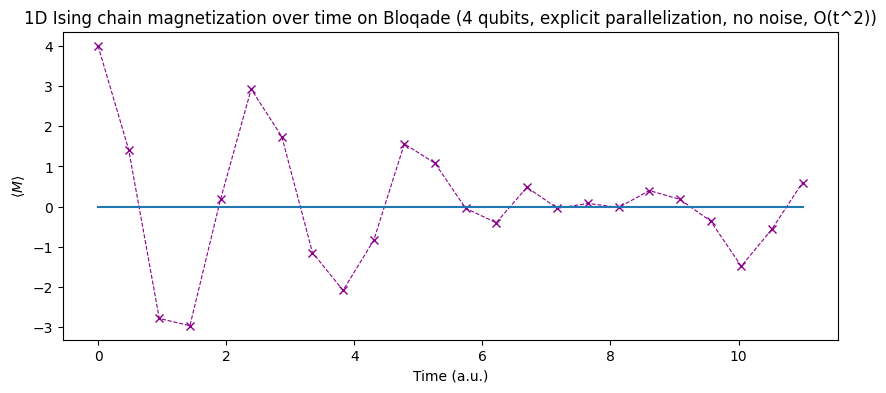

In [54]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 24)
plt.plot(t, explicit_parallel_vals, marker="x", c="darkmagenta", ls="dashed", lw=0.8)
plt.xlabel("Time (a.u.)")
plt.plot(t, np.zeros(24))
plt.ylabel(r"$\langle M \rangle$")
plt.title("1D Ising chain magnetization over time on Bloqade (4 qubits, explicit parallelization, no noise, O(t^2))") 

In [19]:
def SpinChainLieTrotterMaxOpt(n: int, time: int, steps: int, parallelize: bool = True):
    n_qubits = int(2**n)

    @extended_opt
    def trotter_layer(qreg: qasm2.QReg, timestep: int, J: int, h: int): #puts commuting ZZ in parallel
        def get_qubit(x: int):
            return qreg[x % n_qubits]
            
        even_qubits = ilist.map(fn=get_qubit, collection=range(0, n_qubits, 2))
        even_qubits_alt = ilist.map(fn=get_qubit, collection=range(2, n_qubits+1, 2))
        odd_qubits = ilist.map(fn=get_qubit, collection=range(1, n_qubits, 2))
        all_qubits = ilist.map(fn=get_qubit, collection=range(n_qubits))

        # hadamard
        qasm2.parallel.u(qargs=odd_qubits, theta=math.pi/2, phi=0, lam=math.pi)
        # cz
        qasm2.parallel.cz(ctrls=even_qubits, qargs=odd_qubits)
        # rx
        qasm2.parallel.u(qargs=odd_qubits, theta=2*J*timestep, phi=-math.pi/2, lam=math.pi/2)
        # cz
        qasm2.parallel.cz(ctrls=even_qubits, qargs=odd_qubits)
        # h
        qasm2.parallel.u(qargs=odd_qubits, theta=math.pi/2, phi=0, lam=math.pi)
        
        qasm2.parallel.u(qargs=even_qubits, theta=math.pi/2, phi=0, lam=math.pi)
        qasm2.parallel.cz(ctrls=even_qubits_alt, qargs=odd_qubits)
        qasm2.parallel.u(qargs=even_qubits, theta=2*J*timestep, phi=-math.pi/2, lam=math.pi/2)
        qasm2.parallel.cz(ctrls=even_qubits_alt, qargs=odd_qubits)
        qasm2.parallel.u(qargs=even_qubits, theta=math.pi/2, phi=0, lam=math.pi)

        qasm2.parallel.u(qargs=all_qubits, theta=2*h*timestep, phi=-math.pi/2, lam=math.pi/2)

    @extended_opt
    def SpinChainLieTrotterMaxOpt_program():
        if time == 0: 
            creg = qasm2.creg(n_qubits) 
            return creg
        
        qreg = qasm2.qreg(n_qubits)
        creg = qasm2.creg(n_qubits)

        J = 0.2 
        h = 1.2 
        timestep = time/steps 
        for i in range(steps): 
            trotter_layer(qreg, timestep, J, h)
        
        for i in range(n_qubits):
            qasm2.measure(qreg[i],creg[i])

        return creg

    return SpinChainLieTrotterMaxOpt_program

In [55]:
time_interval = 0.5
steps = 24
N = 2
max_opt_vals = [] 

for i in range(steps):
    kernel = SpinChainLieTrotterMaxOpt(N, time_interval*i, i)
    
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = str(key).count('1')
        total_magnetization += value*spin_down * (-1) + value*(2**N - spin_down)

    print("Time " + str(time_interval*i) + ": " + str(total_magnetization/100))
    max_opt_vals.append(total_magnetization/100) 

Time 0.0: 4.0
Time 0.5: 1.54
Time 1.0: -2.8
Time 1.5: -3.3
Time 2.0: 0.06
Time 2.5: 2.82
Time 3.0: 1.78
Time 3.5: -0.9
Time 4.0: -2.24
Time 4.5: -0.74
Time 5.0: 1.34
Time 5.5: 1.04
Time 6.0: -0.6
Time 6.5: -0.4
Time 7.0: -0.64
Time 7.5: -0.08
Time 8.0: -0.1
Time 8.5: 0.24
Time 9.0: 0.82
Time 9.5: 0.34
Time 10.0: -0.16
Time 10.5: -0.42
Time 11.0: 0.08
Time 11.5: 0.92


Text(0.5, 1.0, '1D Ising chain magnetization over time on Bloqade (4 qubits, maximum optimization, no noise, O(t^2))')

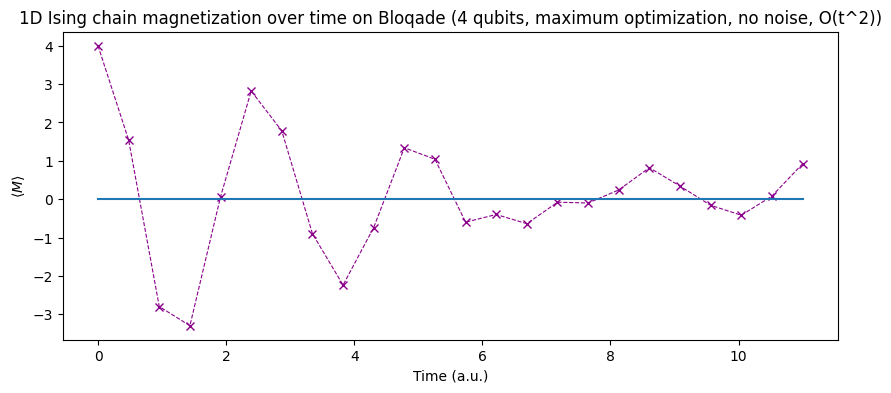

In [56]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 24)
plt.plot(t, max_opt_vals, marker="x", c="darkmagenta", ls="dashed", lw=0.8)
plt.xlabel("Time (a.u.)")
plt.plot(t, np.zeros(24))
plt.ylabel(r"$\langle M \rangle$")
plt.title("1D Ising chain magnetization over time on Bloqade (4 qubits, maximum optimization, no noise, O(t^2))") 

We may see all these plots together, to see which one performed the best.

Text(0.5, 1.0, '1D Ising chain magnetization over time on Bloqade at various optimization levels (no noise, O(t^2))')

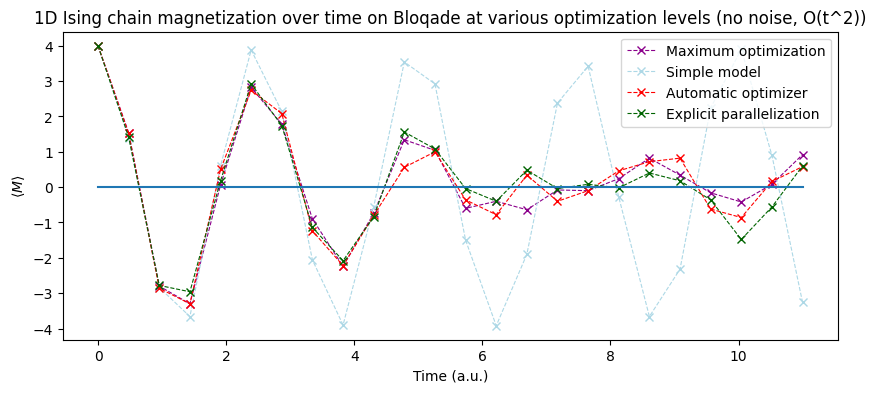

In [58]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 24)
plt.plot(t, max_opt_vals, marker="x", c="darkmagenta", ls="dashed", lw=0.8, label="Maximum optimization")
plt.plot(t, no_noise_2_qubits_lie, marker="x", c="lightblue", ls="dashed", lw=0.8, label="Simple model")
plt.plot(t, parallel_vals, marker="x", c="red", ls="dashed", lw=0.8, label="Automatic optimizer")
plt.plot(t, explicit_parallel_vals, marker="x", c="darkgreen", ls="dashed", lw=0.8, label="Explicit parallelization")
plt.xlabel("Time (a.u.)")
plt.plot(t, np.zeros(24))
plt.legend()
plt.ylabel(r"$\langle M \rangle$")
plt.title("1D Ising chain magnetization over time on Bloqade at various optimization levels (no noise, O(t^2))") 

As may be expected, the maximum optimization case and the automatic optimizer performed the best. Since the maximum optimization with the manual parallelism does not demonstrate marked improvements over solely the automatic optimizer, we may assume that the automatic optimizer is sufficient for these relatively straightforward contexts.

## Adding noise

To test the effects of noise, we may use the default NoisePass method.

In [8]:
from bloqade.qasm2.passes import NoisePass
from bloqade.noise import native

### Potential bug! When using the noise model on the data, the error "QStabilizer::ForceM() forced a measurement with 0 probability!" shows up very frequently (>60% of the runs), which is likely not intended

In [66]:
time_interval = 0.5
steps = 24
N = 2
noisy_vals = [] 

for i in range(steps):
    kernel = SpinChainLieTrotterExplicitParallel(N, time_interval*i, i)
    noise_kernel = kernel.similar()
    extended_opt.run_pass(noise_kernel, parallelize=True)
    NoisePass(extended_opt)(noise_kernel)
    
    noise_kernel = noise_kernel.similar(extended_opt.add(native))
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(noise_kernel, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = str(key).count('1')
        total_magnetization += value*spin_down * (-1) + value*(2**N - spin_down)

    print("Time " + str(time_interval*i) + ": " + str(total_magnetization/100))
    noisy_vals.append(total_magnetization/100) 

Time 0.0: 4.0
Time 0.5: 1.2
Time 1.0: -2.3
Time 1.5: -2.98
Time 2.0: 0.22
Time 2.5: 1.74
Time 3.0: 1.3
Time 3.5: -0.94
Time 4.0: -1.42
Time 4.5: -0.5
Time 5.0: 0.74
Time 5.5: 0.8
Time 6.0: -0.24
Time 6.5: -0.76
Time 7.0: -0.3
Time 7.5: -0.44
Time 8.0: -0.36
Time 8.5: -0.84
Time 9.0: -0.32
Time 9.5: -0.72
Time 10.0: -0.08
Time 10.5: -0.36
Time 11.0: -0.34
Time 11.5: -0.24


Here we see one good dataset without the aforementioned error showing up. The noise's effect can been seen since the second half of the dataset is clearly shifted downward.

Text(0.5, 1.0, '1D Ising chain magnetization over time on Bloqade with noise (O(t^2) Trotterization)')

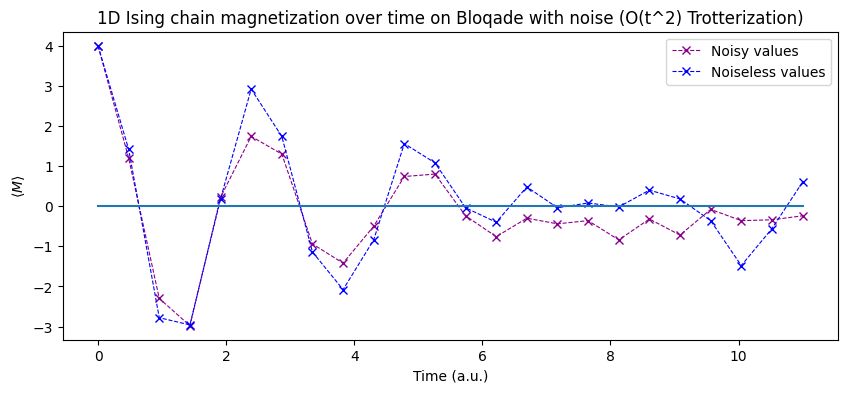

In [71]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 24)
plt.plot(t, noisy_vals, marker="x", c="darkmagenta", ls="dashed", lw=0.8, label="Noisy values")
plt.plot(t, explicit_parallel_vals, marker="x", c="blue", ls="dashed", lw=0.8, label="Noiseless values")
plt.xlabel("Time (a.u.)")
plt.plot(t, np.zeros(24)) 
plt.legend()
plt.ylabel(r"$\langle M \rangle$")
plt.title("1D Ising chain magnetization over time on Bloqade with noise (O(t^2) Trotterization)") 

## Example of an ordered state

Now let us consider an example where $J > h$, i.e. the contribution toward the total energy from the coupling of the spins is stronger than the individual spins; thus they tend to align. We revisit the circuit with heuristic optimization:

In [51]:
def OrderedSpinChain(n: int, time: float, steps: int, parallelize: bool = True):
    n_qubits = int(2**n)
    J = 1.2 # swapped from 0.2
    h = 0.2 # swapped from 1.2

    @extended_opt
    def trotter_layer(qreg: qasm2.QReg, timestep: float, J: float, h: float): #puts commuting ZZ in parallel
        for i in range(0,n_qubits, 2):
            qasm2.cx(qreg[i], qreg[(i+1)%n_qubits])
            qasm2.rz(qreg[(i+1)%n_qubits], 2*J*timestep)
            qasm2.cx(qreg[i], qreg[(i+1)%n_qubits])
        for i in range(1,n_qubits, 2):
            qasm2.cx(qreg[i], qreg[(i+1)%n_qubits])
            qasm2.rz(qreg[(i+1)%n_qubits], 2*J*timestep)
            qasm2.cx(qreg[i], qreg[(i+1)%n_qubits])
        for i in range(n_qubits):
            qasm2.rx(qreg[i], 2*h*timestep)

    @extended_opt(parallelize=parallelize)
    def OrderedSpinChain_program():
        qreg = qasm2.qreg(n_qubits) # creates aligned spin state
        creg = qasm2.creg(n_qubits)
        
        if time != 0 and steps != 0:
            timestep = time/steps 
            for i in range(steps): 
                trotter_layer(qreg, timestep, J, h)
        for i in range(n_qubits):
            qasm2.measure(qreg[i],creg[i])
        return creg

    return OrderedSpinChain_program

In [52]:
time_interval = 0.2
steps = 20
N = 3
ordered_vals = [] 

for i in range(steps):
    kernel = OrderedSpinChain(N, time_interval*i, i, parallelize=True)
    
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = str(key).count('1')
        total_magnetization += value*spin_down * (-1) + value*(2**N - spin_down)

    print("Time " + str(time_interval*i) + ": " + str(total_magnetization/100))
    ordered_vals.append(total_magnetization/100) 

Time 0.0: 8.0
Time 0.2: 7.98
Time 0.4: 7.84
Time 0.6000000000000001: 7.94
Time 0.8: 7.9
Time 1.0: 8.0
Time 1.2000000000000002: 7.96
Time 1.4000000000000001: 7.98
Time 1.6: 7.94
Time 1.8: 7.92
Time 2.0: 7.9
Time 2.2: 7.9
Time 2.4000000000000004: 7.86
Time 2.6: 8.0
Time 2.8000000000000003: 7.9
Time 3.0: 7.92
Time 3.2: 7.9
Time 3.4000000000000004: 7.92
Time 3.6: 7.82
Time 3.8000000000000003: 7.94


Text(0.5, 1.0, '1D Ising chain, ordered phase magnetization over time on Bloqade, (4 qubits, optimized, no noise, O(t^2))')

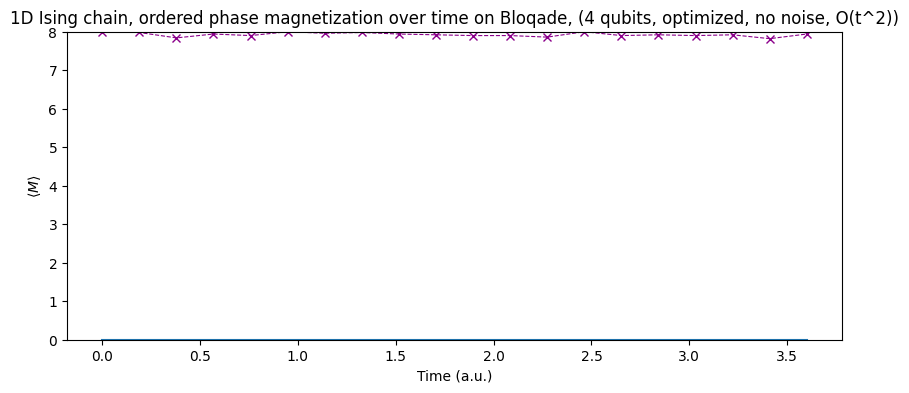

In [ ]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 20)
plt.plot(t, ordered_vals, marker="x", c="darkmagenta", ls="dashed", lw=0.8)
plt.xlabel("Time (a.u.)")
plt.ylim([0,8.2])
plt.plot(t, np.zeros(20))
plt.ylabel(r"$\langle M \rangle$")
plt.title("1D Ising chain, ordered phase magnetization over time on Bloqade, (4 qubits, optimized, no noise, O(t^2))") 

*Very interesting physics can be modeled with such a spin chain.* For example, questions like "how long does it take for states to converge" or "will highly entangled states find their ground state" may be answered with such a simulation.

# Time Dependent Hamiltonian Evolution

In the previous results, we observed that the time-evolution behavior of an initial all-spin-up state differs significantly depending on whether the TFIM Hamiltonian is in the ordered or disordered regime. Building on this, we now consider a time-dependent Hamiltonian in which the parameters are varied slowly. Specifically, we study two scenarios: one in which the parameters are tuned without crossing the critical point, and another in which the evolution passes through the critical point. We compare the system’s behavior in both cases to examine how the presence or absence of a phase transition affects the dynamics.

## Evolution Algorithm

Our algorithm for simulating Trotterized time evolution allows the Hamiltonian parameters to vary at each Trotter step. To achieve this, we implemented a linear interpolation function that updates the values of `J` and `h` based on the current time step. 

After each application of a Trotter evolution layer, the interpolator computes a new set of parameters, which are then used to construct the next evolution layer. This approach enables smooth, time-dependent evolution of the system across the entire simulation.

In [6]:
@ir.dialect_group(qasm2.extended)
def extended_opt(self):
    native_rewrite = Walk(RydbergGateSetRewriteRule(self)) # use Kirin's functionality to walk code line by line while applying neutral-atom gate decomposition as defined in Bloqade
    parallelize_pass = UOpToParallel(self) # review the code and apply parallelization using a heuristic
    agg_fold = QASM2Fold(self) # supports parallelization by unfolding loops to search for parallelization opportunities

    # here we define our new compiler pass
    def run_pass(
        kernel: ir.Method,
        *,
        fold: bool = True,
        typeinfer: bool = True,
        parallelize: bool = False,
    ):
        assert qasm2.extended.run_pass is not None
        qasm2.extended.run_pass(kernel, fold=fold, typeinfer=typeinfer) # apply the original run_pass to the lowered kernel
        native_rewrite.rewrite(kernel.code) # decompose all gates in the circuit to neutral atom gate set

        # here goes our parallelization optimizer; the order of the commands here matters!
        if parallelize:
            agg_fold.fixpoint(kernel)
            parallelize_pass(kernel)

    return run_pass

def unopt(self):
    native_rewrite = Walk(RydbergGateSetRewriteRule(self)) # use Kirin's functionality to walk code line by line while applying neutral-atom gate decomposition as defined in Bloqade
    parallelize_pass = UOpToParallel(self) # review the code and apply parallelization using a heuristic
    agg_fold = QASM2Fold(self) # supports parallelization by unfolding loops to search for parallelization opportunities

    # here we define our new compiler pass
    def run_pass(
        kernel: ir.Method,
        *,
        fold: bool = False,
        typeinfer: bool = False,
        parallelize: bool = False,
    ):
        assert qasm2.extended.run_pass is not None
        qasm2.extended.run_pass(kernel, fold=fold, typeinfer=typeinfer) # apply the original run_pass to the lowered kernel
        native_rewrite.rewrite(kernel.code) # decompose all gates in the circuit to neutral atom gate set

        # here goes our parallelization optimizer; the order of the commands here matters!
        if parallelize:
            agg_fold.fixpoint(kernel)
            parallelize_pass(kernel)

    return run_pass

def SpinChainLieTrotterTD(n: int, time: float, steps: int, 
                         h_start: float, h_end: float,
                         J_start: float, J_end: float,
                         parallelize: bool = True):
    n_qubits = int(2**n)
    
    @extended_opt
    def trotter_layer(qreg: qasm2.QReg, timestep: float, J: float, h: float):
        # Interaction terms (ZZ)
        for i in range(n_qubits):
            qasm2.cx(qreg[i], qreg[(i+1)%n_qubits])
            qasm2.rz(qreg[(i+1)%n_qubits], 2*J*timestep)
            qasm2.cx(qreg[i], qreg[(i+1)%n_qubits])
        # Field terms (X)
        for i in range(n_qubits):
            qasm2.rx(qreg[i], 2*h*timestep)

    @extended_opt(parallelize=parallelize)
    def SpinChainLieTrotterTD_program():
        if time == 0: 
            creg = qasm2.creg(n_qubits) 
            return creg
        
        qreg = qasm2.qreg(n_qubits)
        creg = qasm2.creg(n_qubits)

        timestep = time / steps
        for step in range(steps):
            # Linear interpolation of parameters
            t_frac = step / steps
            J = J_start + (J_end - J_start) * t_frac
            h = h_start + (h_end - h_start) * t_frac
            
            trotter_layer(qreg, timestep, J, h)
        
        # Measurement
        for i in range(n_qubits):
            qasm2.measure(qreg[i], creg[i])

        return creg

    return SpinChainLieTrotterTD_program

## No Phase Transition

Here we implement the Trotterized time evolution with changing Hamiltonian parameters that does not change critical point. By adiabatic theorem, the system should remain in the instantaneous ground state of the system. Thus, when we measure the magnetization we should discover that it is close to 4

In [7]:
time_interval = 0.2
steps = 24
N = 3

# Time-dependent parameters (linear interpolation)
h_start, h_end = 0.2, 0.4  # Transverse field range
J_start, J_end = 1.2, 1.0  # Interaction strength range

mag_vals = []
time_vals = []

print("\nTime Evolution of Magnetization")
print("-----------------------------")
print("Time (t) | h(t) | J(t) | Magnetization (M)")
print("------------------------------------------")

for i in range(steps + 1):  # +1 to include t=0
    current_time = time_interval * i
    time_vals.append(current_time)
    
    # Calculate current h and J values (linear interpolation)
    t_frac = i / steps
    h = h_start + (h_end - h_start) * t_frac
    J = J_start + (J_end - J_start) * t_frac
    
    # Time-dependent Trotter evolution
    kernel_PT = SpinChainLieTrotterTD(
        n=N, 
        time=current_time, 
        steps=i if i > 0 else 1,  # Avoid division by zero
        h_start=h, h_end=h,  # Constant within this step
        J_start=J, J_end=J,
        parallelize=True
    )
    
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel_PT, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result: "".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = key.count('1')
        total_magnetization += value * ( (2**N - 2*spin_down) / 2 )  # Simplified (-1/2 for 1, +1/2 for 0)
    
    avg_magnetization = total_magnetization / 100
    mag_vals.append(avg_magnetization)
    
    # Formatted output
    print(f"{current_time:.2f}     | {h:.2f} | {J:.2f} | {avg_magnetization:.3f}")


Time Evolution of Magnetization
-----------------------------
Time (t) | h(t) | J(t) | Magnetization (M)
------------------------------------------
0.00     | 0.20 | 1.20 | 4.000
0.20     | 0.20 | 1.20 | 4.000
0.40     | 0.20 | 1.20 | 3.990
0.60     | 0.20 | 1.20 | 3.950
0.80     | 0.20 | 1.20 | 3.940
1.00     | 0.20 | 1.20 | 3.990
1.20     | 0.20 | 1.20 | 4.000
1.40     | 0.20 | 1.20 | 3.970
1.60     | 0.20 | 1.20 | 3.980
1.80     | 0.20 | 1.20 | 4.000
2.00     | 0.20 | 1.20 | 3.940
2.20     | 0.20 | 1.20 | 3.930
2.40     | 0.20 | 1.20 | 3.910
2.60     | 0.20 | 1.20 | 3.970
2.80     | 0.20 | 1.20 | 3.970
3.00     | 0.20 | 1.20 | 3.970
3.20     | 0.20 | 1.20 | 3.930
3.40     | 0.20 | 1.20 | 3.930
3.60     | 0.20 | 1.20 | 3.940
3.80     | 0.20 | 1.20 | 3.880
4.00     | 0.20 | 1.20 | 3.950
4.20     | 0.20 | 1.20 | 3.970
4.40     | 0.20 | 1.20 | 3.950
4.60     | 0.20 | 1.20 | 3.940
4.80     | 0.20 | 1.20 | 3.960


## Across Critical Point

Even though the parameter is tunned slowly, at the cirtical point the gap between ground state and excited state is closed, so the condition for adiabatic theorem is no longer staisfied. In this case, we observe that the initial state where spin alinged in z-direction gradually slide to the new disordered ground state.

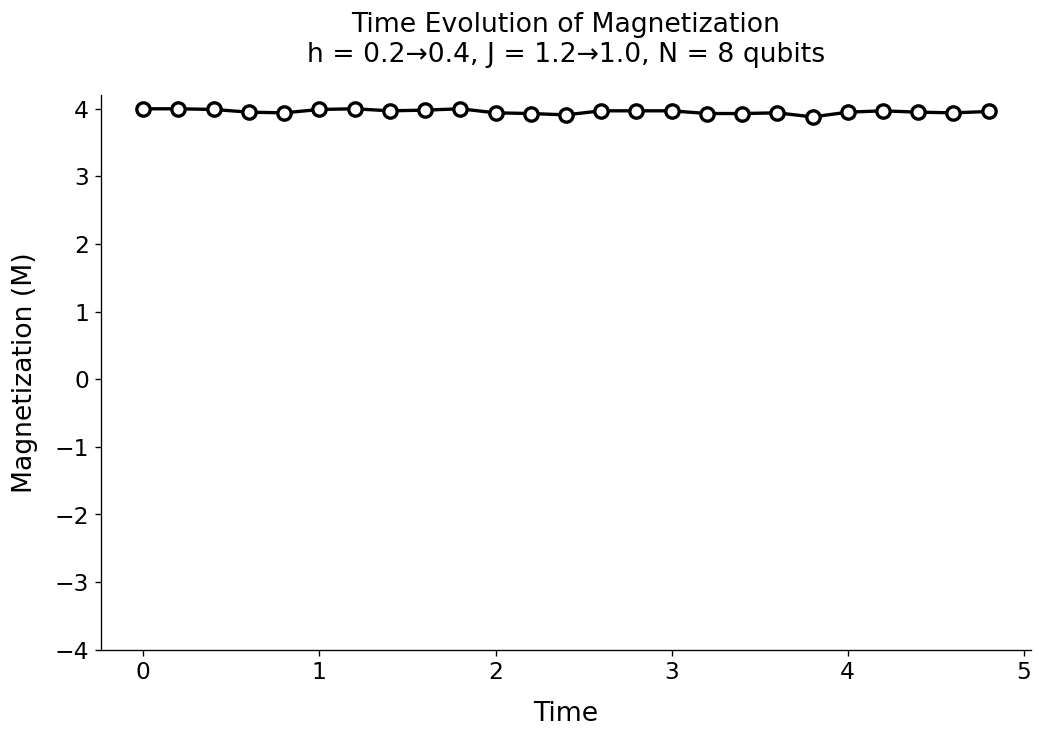

In [15]:
# Plotting
h_start, h_end = 0.2, 0.4  # Transverse field range
J_start, J_end = 1.2, 1.0  # Interaction strength range
plt.figure(figsize=(10, 6), dpi=120)  # Larger figure with higher resolution

# Main plot
plt.plot(time_vals, mag_vals, 'o-', 
         color='black', 
         markersize=8,
         linewidth=2,
         markerfacecolor='white',
         markeredgewidth=2)

# Customize appearance
plt.title("Time Evolution of Magnetization\n" +
          f"h = {h_start}→{h_end}, J = {J_start}→{J_end}, N = {2**N} qubits",
          fontsize=16, pad=20)
plt.xlabel("Time", fontsize=16, labelpad=10)
plt.ylabel("Magnetization (M)", fontsize=16, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-4,4.2)

# Remove top/right spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save and show
plt.savefig('magnetization_evolution.png', bbox_inches='tight', dpi=300)
plt.show()

In [16]:
time_interval = 0.2
steps = 24
N = 3

# Time-dependent parameters (linear interpolation)
h_start, h_end = 0.5, 0.6  # Transverse field range
J_start, J_end = 0.6, 0.5  # Interaction strength range

mag_vals = []
time_vals = []

print("\nTime Evolution of Magnetization")
print("-----------------------------")
print("Time (t) | h(t) | J(t) | Magnetization (M)")
print("------------------------------------------")

for i in range(steps + 1):  # +1 to include t=0
    current_time = time_interval * i
    time_vals.append(current_time)
    
    # Calculate current h and J values (linear interpolation)
    t_frac = i / steps
    h = h_start + (h_end - h_start) * t_frac
    J = J_start + (J_end - J_start) * t_frac
    
    # Time-dependent Trotter evolution
    kernel_PT = SpinChainLieTrotterTD(
        n=N, 
        time=current_time, 
        steps=i if i > 0 else 1,  # Avoid division by zero
        h_start=h, h_end=h,  # Constant within this step
        J_start=J, J_end=J,
        parallelize=True
    )
    
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel_PT, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result: "".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = key.count('1')
        total_magnetization += value * ( (2**N - 2*spin_down) / 2 )  # Simplified (-1/2 for 1, +1/2 for 0)
    
    avg_magnetization = total_magnetization / 100
    mag_vals.append(avg_magnetization)
    
    # Formatted output
    print(f"{current_time:.2f}     | {h:.2f} | {J:.2f} | {avg_magnetization:.3f}")


Time Evolution of Magnetization
-----------------------------
Time (t) | h(t) | J(t) | Magnetization (M)
------------------------------------------
0.00     | 0.50 | 0.60 | 4.000
0.20     | 0.50 | 0.60 | 3.900
0.40     | 0.50 | 0.60 | 3.710
0.60     | 0.50 | 0.60 | 3.370
0.80     | 0.50 | 0.60 | 3.190
1.00     | 0.50 | 0.60 | 2.650
1.20     | 0.50 | 0.60 | 2.480
1.40     | 0.50 | 0.60 | 2.480
1.60     | 0.50 | 0.60 | 2.330
1.80     | 0.50 | 0.60 | 2.110
2.00     | 0.50 | 0.60 | 2.220
2.20     | 0.50 | 0.60 | 1.620
2.40     | 0.50 | 0.60 | 1.990
2.60     | 0.50 | 0.60 | 1.800
2.80     | 0.50 | 0.60 | 1.520
3.00     | 0.50 | 0.60 | 1.510
3.20     | 0.50 | 0.60 | 1.650
3.40     | 0.50 | 0.60 | 1.190
3.60     | 0.50 | 0.60 | 0.870
3.80     | 0.50 | 0.60 | 1.530
4.00     | 0.50 | 0.60 | 1.280
4.20     | 0.50 | 0.60 | 1.120
4.40     | 0.50 | 0.60 | 1.250
4.60     | 0.50 | 0.60 | 1.610
4.80     | 0.50 | 0.60 | 1.070


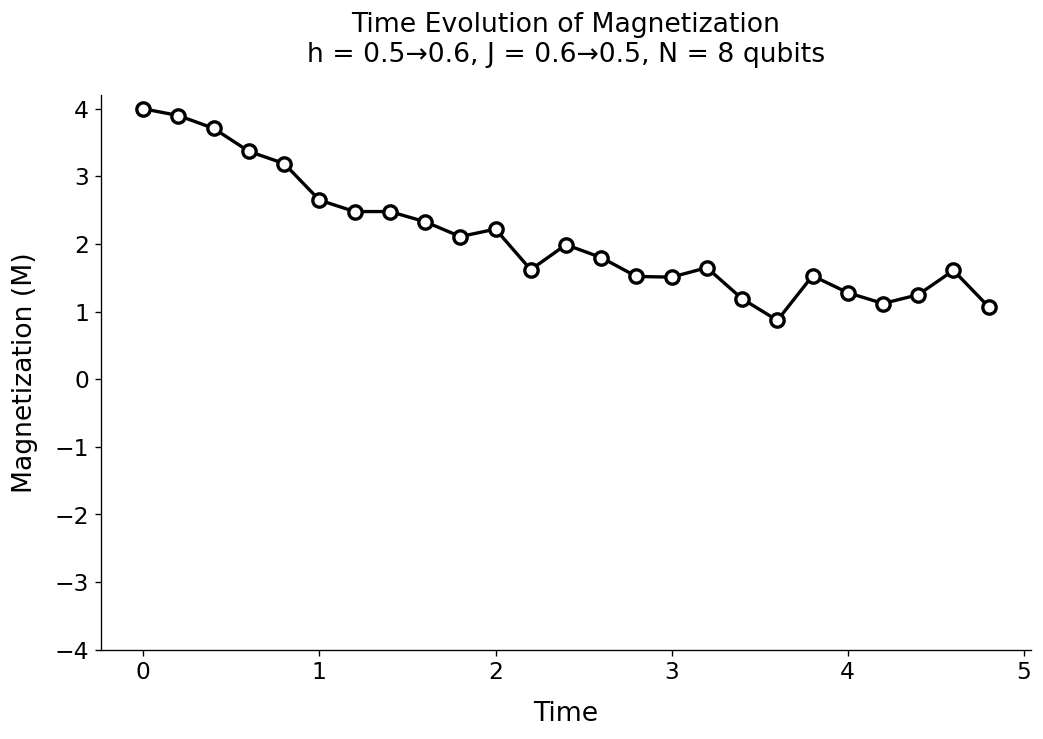

In [18]:
# Plotting
# Time-dependent parameters (linear interpolation)
h_start, h_end = 0.5, 0.6  # Transverse field range
J_start, J_end = 0.6, 0.5  # Interaction strength range
plt.figure(figsize=(10, 6), dpi=120)  # Larger figure with higher resolution

# Main plot
plt.plot(time_vals, mag_vals, 'o-', 
         color='black', 
         markersize=8,
         linewidth=2,
         markerfacecolor='white',
         markeredgewidth=2)

# Customize appearance
plt.title("Time Evolution of Magnetization\n" +
          f"h = {h_start}→{h_end}, J = {J_start}→{J_end}, N = {2**N} qubits",
          fontsize=16, pad=20)
plt.xlabel("Time", fontsize=16, labelpad=10)
plt.ylabel("Magnetization (M)", fontsize=16, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-4,4.2)

# Remove top/right spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save and show
plt.savefig('magnetization_evolution.png', bbox_inches='tight', dpi=300)
plt.show()